In [1]:
# Part 1: Setup and Data Preparation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize, brentq
from collections import defaultdict, Counter
import math
from numpy.polynomial.chebyshev import chebval, Chebyshev
from matplotlib.ticker import PercentFormatter
import matplotlib.patheffects as pe



# Configuration
# Define the settlement date for all calculations (day the dataframe was parsed).
SETTLEMENT_DATE = datetime(2025, 2, 24)
FILE_PATH = "/Users/souhil/Desktop/Courses/NYU/Valuation for Financial Engineering/Projects/MP02/US_Treasury_Data for MiniProject 2.xlsx"
FACE_VALUE = 100

# Data Loading and Initial Processing
bonds_df = pd.read_excel(FILE_PATH, sheet_name="Bonds")

# Convert date columns to datetime objects for calculations.
bonds_df["Issue Date"] = pd.to_datetime(bonds_df["Issue Date"])
bonds_df["Maturity"] = pd.to_datetime(bonds_df["Maturity"])

# Calculate the mid-point of the bid-ask spread to get a representative clean price.
bonds_df["Clean Price"] = (bonds_df["Bid Price"] + bonds_df["Ask Price"]) / 2

# Calculate the semi-annual coupon payment per $100 face value.
bonds_df["Coupon Rate"] = bonds_df["Cpn"] / 100
bonds_df["Coupon Payment"] = FACE_VALUE * bonds_df["Coupon Rate"] / 2


def calculate_accrued_interest(issue_date, maturity_date, coupon_payment, settlement_date):
    # Generate the full coupon schedule, starting from maturity and stepping back every 6 months. This is more robust than stepping forward from issue date.
    coupon_dates = []
    current_date = maturity_date
    while current_date > issue_date:
        coupon_dates.append(current_date)
        current_date -= relativedelta(months=6)
    coupon_dates.reverse()

    if not coupon_dates:
        return 0.0

    # Find the last coupon date before settlement and the next one after.
    last_coupon_date = issue_date
    next_coupon_date = None
    for date in coupon_dates:
        if date <= settlement_date:
            last_coupon_date = date
        elif date > settlement_date:
            next_coupon_date = date
            break

    # If settlement is after the last coupon payment, no interest has accrued.
    if next_coupon_date is None:
        return 0.0

    # Calculate the accrued interest using a simplified Actual/Actual convention.
    days_in_period = (next_coupon_date - last_coupon_date).days
    days_accrued = (settlement_date - last_coupon_date).days

    if days_in_period == 0:
        return 0.0

    accrued_fraction = days_accrued / days_in_period
    return coupon_payment * accrued_fraction


# Calculate accrued interest and dirty price for each bond.
bonds_df["Accrued Interest"] = bonds_df.apply(
    lambda row: calculate_accrued_interest(
        row["Issue Date"],
        row["Maturity"],
        row["Coupon Payment"],
        SETTLEMENT_DATE
    ),
    axis=1)
bonds_df["Dirty Price"] = bonds_df["Clean Price"] + bonds_df["Accrued Interest"]



def yearfrac_actact_isda(d0: date, d1: date) -> float:
    if d1 == d0:
        return 0.0
    # Ensure d0 <= d1
    if d1 < d0:
        d0, d1 = d1, d0

    yf = 0.0
    cur = d0
    while cur < d1:
        # End of current calendar year (exclusive)
        year_end = date(cur.year, 12, 31) + timedelta(days=1)  # Jan 1 next year
        seg_end = min(d1, year_end)
        days_seg = (seg_end - cur).days
        # Days in the current calendar year: 365 or 366 (leap year)
        days_year = 366 if (date(cur.year, 12, 31) - date(cur.year, 1, 1)).days + 1 == 366 else 365
        yf += days_seg / days_year
        cur = seg_end
    return yf

def generate_bond_cashflows_T(bonds_df, settlement_date, face_value=100.0):
    out = []
    for _, row in bonds_df.iterrows():
        # Coupon schedule 
        cds = []
        cur = row["Maturity"]
        while cur > row["Issue Date"]:
            cds.append(cur)
            cur -= relativedelta(months=6)
        cds.sort()

        # Future cashflows only 
        fut = []
        for d in cds:
            if d > settlement_date:
                fut.append({"date": d, "amount": row["Coupon Payment"]})

        if not fut:
            continue

        # Add principal at maturity 
        for cf in fut:
            if cf["date"] == row["Maturity"]:
                cf["amount"] += face_value
                break

        # Convert each date -> ACT/ACT years t
        cashflows_T = []
        for cf in fut:
            t = yearfrac_actact_isda(settlement_date.date(), cf["date"].date())
            cashflows_T.append({"t": t, "amount": cf["amount"]})

        # Store maturity as ACT/ACT years
        maturity_T = yearfrac_actact_isda(settlement_date.date(), row["Maturity"].date())

        out.append({
            "Maturity_T": maturity_T,
            "Dirty Price": row["Dirty Price"],
            "Cashflows": cashflows_T
        })
    return out

all_cashflows_T = generate_bond_cashflows_T(bonds_df, SETTLEMENT_DATE)

In [2]:
# NSS Model Functions

def nelson_siegel_svensson_yield(t, beta_0, beta_1, beta_2, beta_3, tau_1, tau_2):
    # Ensure positive taus
    tau_1 = max(tau_1, 1e-9)
    tau_2 = max(tau_2, 1e-9)

    # Handle t ~ 0: limit is beta0 + beta1
    if t <= 1e-12:
        return beta_0 + beta_1

    term_1 = (1.0 - math.exp(-t / tau_1)) / (t / tau_1)
    term_2 = term_1 - math.exp(-t / tau_1)
    term_3 = (1.0 - math.exp(-t / tau_2)) / (t / tau_2) - math.exp(-t / tau_2)

    return beta_0 + beta_1*term_1 + beta_2*term_2 + beta_3*term_3


def model_bond_price(cashflows, params):
    beta_0, beta_1, beta_2, beta_3, tau_1, tau_2 = params
    price = 0.0
    for cf in cashflows:
        t = cf['t']
        y_t = nelson_siegel_svensson_yield(t, beta_0, beta_1, beta_2, beta_3, tau_1, tau_2)
        x = -y_t * t
        # overflow/NaN guard
        if not math.isfinite(x) or x < -750 or x > 750:
            return float('inf') 
        price += cf['amount'] * math.exp(x)
    return price


def sse_objective(params, bonds_data):
    tau_1, tau_2 = params[4], params[5]
    if tau_1 <= 0 or tau_2 <= 0:
        return 1e12

    total = 0.0
    for bond in bonds_data:
        observed = bond['Dirty Price']
        model_p = model_bond_price(bond['Cashflows'], params)
        if not math.isfinite(model_p):
            return 1e12
        err = model_p - observed
        total += err * err
    return total



# Optimization Setup 
BOUNDS_NSS = [
    (-0.05, 0.20),  # beta_0 (level)
    (-0.20, 0.20),  # beta_1 (slope)
    (-0.20, 0.20),  # beta_2 (curv1)
    (-0.20, 0.20),  # beta_3 (curv2)
    (0.05, 30.0),   # tau_1
    (0.05, 30.0),   # tau_2
]


x0 = np.array([0.03, -0.01, 0.01, 0.001, 1.0, 5.0])

print("Starting NSS optimization...")
optimization_result = minimize(
    sse_objective,
    x0,
    args=(all_cashflows_T,),
    method='L-BFGS-B',
    bounds=BOUNDS_NSS,
    options={'disp': True, 'ftol': 1e-8, 'maxiter': 20000})

fitted_params = optimization_result.x
beta_0, beta_1, beta_2, beta_3, tau_1, tau_2 = fitted_params
min_sse = optimization_result.fun

print("\nOptimization Results")
print(f"Success: {optimization_result.success}")
print(f"Message: {optimization_result.message}")
print(f"Minimum SSE: {min_sse:,.6f}")
print("\nFitted Parameters:")
print(f"  beta_0 (Level): {beta_0:.6f}")
print(f"  beta_1 (Slope): {beta_1:.6f}")
print(f"  beta_2 (Curv1): {beta_2:.6f}")
print(f"  beta_3 (Curv2): {beta_3:.6f}")
print(f"  tau_1: {tau_1:.6f}")
print(f"  tau_2: {tau_2:.6f}")


Starting NSS optimization...

Optimization Results
Success: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Minimum SSE: 32.677468

Fitted Parameters:
  beta_0 (Level): 0.049998
  beta_1 (Slope): -0.009801
  beta_2 (Curv1): 0.008867
  beta_3 (Curv2): -0.027199
  tau_1: 1.106362
  tau_2: 2.259207


In [3]:
# NS Specific Yield Function (Simplified NSS)

def nelson_siegel_yield(t, beta_0, beta_1, beta_2, tau_1):
    # ensure positive tau
    tau_1 = max(tau_1, 1e-9)
    # t -> 0 limit is beta0 + beta1
    if t <= 1e-12:
        return beta_0 + beta_1

    term_1 = (1.0 - math.exp(-t / tau_1)) / (t / tau_1)
    term_2 = term_1 - math.exp(-t / tau_1)
    return beta_0 + beta_1 * term_1 + beta_2 * term_2

def ns_model_bond_price(cashflows, params):
    beta_0, beta_1, beta_2, tau_1 = params
    price = 0.0
    for cf in cashflows:
        t = cf['t']
        y_t = nelson_siegel_yield(t, beta_0, beta_1, beta_2, tau_1)
        x = -y_t * t
        # overflow/NaN guard
        if not math.isfinite(x) or x < -750 or x > 750:
            return float('inf')
        price += cf['amount'] * math.exp(x)
    return price

def ns_sse_objective(params, bonds_data):
    if params[3] <= 0:
        return 1e12
    total = 0.0
    for bond in bonds_data:
        observed = bond['Dirty Price']
        model_p = ns_model_bond_price(bond['Cashflows'], params)
        if not math.isfinite(model_p):
            return 1e12
        err = model_p - observed
        total += err * err
    return total

# Optimization Setup and Run 
BOUNDS_NS = [
    (-0.05, 0.20),  # beta_0 (level)
    (-0.20, 0.20),  # beta_1 (slope)
    (-0.20, 0.20),  # beta_2 (curv1)
    (0.05, 30.0),   # tau_1
]

x0_ns = np.array([0.0521, -0.0107, 0.0046, 3.6026])



print("Starting Nelson–Siegel (NS) optimization…")
optimization_result_ns = minimize(
    ns_sse_objective,
    x0_ns,
    args=(all_cashflows_T,),
    method='L-BFGS-B',
    bounds=BOUNDS_NS,
    options={'disp': True, 'ftol': 1e-8, 'maxiter': 20000}
)

fitted_params_ns = optimization_result_ns.x
min_sse_ns = optimization_result_ns.fun

print("\n\nResults")
print("Success:", optimization_result_ns.success)
print("Message:", optimization_result_ns.message)
print(f"Minimum SSE (NS): {min_sse_ns:,.6f}")
print("\n\nFitted NS Parameters:")
print(f"beta_0 (Level): {fitted_params_ns[0]:.6f}")
print(f"beta_1 (Slope): {fitted_params_ns[1]:.6f}")
print(f"beta_2 (Curv1): {fitted_params_ns[2]:.6f}")
print(f"tau_1:          {fitted_params_ns[3]:.6f}")

Starting Nelson–Siegel (NS) optimization…


Results
Success: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Minimum SSE (NS): 33.163012


Fitted NS Parameters:
beta_0 (Level): 0.050063
beta_1 (Slope): -0.006859
beta_2 (Curv1): -0.017615
tau_1:          2.621500


In [4]:
# Compute YTM from bond prices to plot them along our yield curve
def ytm_cc_from_price(bond, target_price):
    t = np.array([cf["t"] for cf in bond["Cashflows"]], float)
    a = np.array([cf["amount"] for cf in bond["Cashflows"]], float)
    # Objective in y
    f = lambda y: np.sum(a * np.exp(-y * t)) - target_price
    # Robust bracket
    lo, hi = -0.05, 0.30
    # Expand bracket if necessary
    for _ in range(3):
        try:
            return brentq(f, lo, hi)
        except ValueError:
            lo -= 0.05; hi += 0.10
    # Fallback: NaN if no root found
    return np.nan

def nss_zero_on_grid(T_grid, theta):
    b0,b1,b2,b3,t1,t2 = theta
    return np.array([nelson_siegel_svensson_yield(t, b0,b1,b2,b3,t1,t2) for t in T_grid], float)

def ns_zero_on_grid(T_grid, theta):
    b0,b1,b2,t1 = theta
    return np.array([nelson_siegel_yield(t, b0,b1,b2,t1) for t in T_grid], float)

# build grid and compute curves

T_max  = max(b["Maturity_T"] for b in all_cashflows_T)
T_grid = np.linspace(0.01, T_max, 400)

Y_nss  = nss_zero_on_grid(T_grid, fitted_params)
Y_ns   = ns_zero_on_grid(T_grid, fitted_params_ns)

# observed YTM (from market dirty prices)

T_mkt, YTM_mkt = [], []
for b in all_cashflows_T:
    T_mkt.append(b["Maturity_T"])
    YTM_mkt.append(ytm_cc_from_price(b, b["Dirty Price"]))
T_mkt = np.array(T_mkt, float)
YTM_mkt = np.array(YTM_mkt, float)


In [5]:
# Chebyshev deg-4 zero-curve (continuous compounding) ---

def _scale_to_cheb_domain(t: float, T_max: float) -> float:
    if T_max <= 0:
        raise ValueError("T_max must be positive.")
    tt = min(max(t, 0.0), T_max)
    return 2.0 * (tt / T_max) - 1.0

def cheb_yield_cc(t: float, coeffs: np.ndarray, T_max: float) -> float:
    x = _scale_to_cheb_domain(t, T_max)
    return float(chebval(x, coeffs))  # continuous-compound zero rate

def cheb_price_from_zero_cc(cashflows, coeffs, T_max: float) -> float:
    p = 0.0
    for cf in cashflows:
        t = cf["t"]
        y = cheb_yield_cc(t, coeffs, T_max)
        x = -y * t
        if (not math.isfinite(x)) or x < -750 or x > 750:
            return float("inf")
        p += cf["amount"] * math.exp(x)
    return p

def cheb_sse_price_relative(coeffs: np.ndarray, bonds_data, T_max: float) -> float:
    # soft regularization on coefficients (small ridge)
    lam = 1e-6
    total = lam * float(np.sum(coeffs[1:]**2))  # don't penalize the level too much

    for b in bonds_data:
        pmkt = b["Dirty Price"]
        pmdl = cheb_price_from_zero_cc(b["Cashflows"], coeffs, T_max)
        if (not math.isfinite(pmdl)) or pmkt <= 0:
            return 1e12
        e = (pmdl - pmkt) / pmkt
        total += e * e
    return total

# Chebyshev init 
T_max = max(b["Maturity_T"] for b in all_cashflows_T)
x_cheb = 2.0 * (T_mkt / T_max) - 1.0  # map to [-1,1]

# Fit deg-4 Chebyshev to observed YTM (continuous comp.) for a good starting point
cheb_fit = Chebyshev.fit(x_cheb, YTM_mkt, deg=4, domain=[-1, 1])
x0_cheb = np.array(cheb_fit.coef, dtype=float)  # shape (5,)


# Bounds for Chebyshev coefficients 
# Allow level in [0%, 20%], others in ±20%.
BOUNDS_CHEB = [(0.00, 0.20),  # c0 ~ overall level
               (-0.20, 0.20), # c1
               (-0.20, 0.20), # c2
               (-0.20, 0.20), # c3
               (-0.20, 0.20)] # c4

# Clip initial guess into bounds
def _clip_x0(x0, bounds):
    lo = np.array([b[0] for b in bounds], float)
    hi = np.array([b[1] for b in bounds], float)
    return np.minimum(np.maximum(x0, lo), hi)

x0_cheb = _clip_x0(x0_cheb, BOUNDS_CHEB)

print("Starting Chebyshev (deg-4) optimization…")
optimization_result_cheb = minimize(
    lambda c: cheb_sse_price_relative(c, all_cashflows_T, T_max),
    x0_cheb,
    method="L-BFGS-B",
    bounds=BOUNDS_CHEB,
    options={"disp": True, "ftol": 1e-8, "maxiter": 20000}
)

fitted_coeffs_cheb = optimization_result_cheb.x
min_sse_cheb = optimization_result_cheb.fun

print("\nChebyshev (deg-4) Optimization Results")
print("Success:", optimization_result_cheb.success)
print("Message:", optimization_result_cheb.message)
print(f"Minimum SSE (Cheb): {min_sse_cheb:,.6f}")
print("Fitted Chebyshev coeffs (c0..c4):", ", ".join(f"{v:.6f}" for v in fitted_coeffs_cheb))


Starting Chebyshev (deg-4) optimization…

Chebyshev (deg-4) Optimization Results
Success: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Minimum SSE (Cheb): 0.000835
Fitted Chebyshev coeffs (c0..c4): 0.044658, 0.003226, -0.001169, -0.001036, -0.000020


Bootstrapping 218 maturity nodes (ACT/ACT), log-DF interpolation...
  Node   1/218: T=0.010959y  y=3.529513%
  Node   2/218: T=0.052055y  y=3.910491%
  Node   3/218: T=0.095890y  y=4.105554%
  Node   4/218: T=0.136986y  y=4.115513%
  Node   5/218: T=0.178082y  y=4.204586%
  Node   6/218: T=0.219178y  y=4.177123%
  Node   7/218: T=0.263014y  y=4.243610%
  Node   8/218: T=0.304110y  y=4.249637%
  Node   9/218: T=0.345205y  y=4.200393%
  Node  10/218: T=0.386301y  y=4.260337%
  Node  11/218: T=0.430137y  y=4.250904%
  Node  12/218: T=0.471233y  y=4.115125%
  Node  13/218: T=0.515068y  y=4.228855%
  Node  14/218: T=0.556164y  y=4.208587%
  Node  15/218: T=0.597260y  y=4.210168%
  Node  16/218: T=0.638356y  y=4.186212%
  Node  17/218: T=0.682192y  y=4.176089%
  Node  18/218: T=0.723288y  y=4.211371%
  Node  19/218: T=0.764384y  y=4.198411%
  Node  20/218: T=0.805479y  y=4.163573%
  Node  21/218: T=0.849315y  y=4.145511%
  Node  22/218: T=0.890411y  y=4.137000%
  Node  23/218: T=0.934247y  y

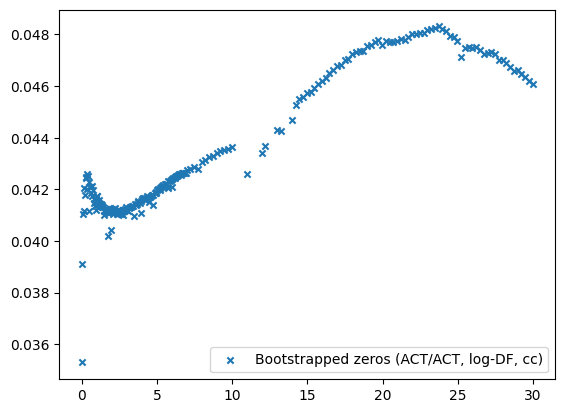

In [6]:
# Bootstrapping estimation with linear interpolation on log discount factor. 

def bootstrap_zero_actact_logdf_with_diagnostics(all_cashflows_T, *, verbose=True, sanity_checks=True, tol=1e-10):
    # Group bonds by maturity T (round to squash float dust)
    by_T = defaultdict(list)
    for b in all_cashflows_T:
        Tm = float(b["Maturity_T"])
        Tm_key = round(Tm, 10)
        by_T[Tm_key].append(b)

    Ts_sorted = sorted(by_T.keys())
    zero_nodes = []  # (T, y(T))

    # Diagnostics trackers
    interpolated_counter = Counter()
    exact_hit_counter = Counter()
    n_interpolated_total = 0
    n_exact_total = 0

    if verbose:
        print(f"Bootstrapping {len(Ts_sorted)} maturity nodes (ACT/ACT), log-DF interpolation...")

    for idx, Tm in enumerate(Ts_sorted, 1):
        dfs_this_T = []

        for bond in by_T[Tm]:
            pmkt = float(bond["Dirty Price"])
            pv_known = 0.0

            if zero_nodes:
                T_known = np.array([z[0] for z in zero_nodes], dtype=float)
                logDF_known = np.array([-z[1]*z[0] for z in zero_nodes], dtype=float)

            # Discount intermediate coupons (all but final)
            for cf in bond["Cashflows"][:-1]:
                t = float(cf["t"])
                a = float(cf["amount"])

                if not zero_nodes:
                    # No earlier nodes on the very first maturity → nothing to discount
                    continue

                # Known nodes (sorted by construction)
                T_known = np.array([z[0] for z in zero_nodes], dtype=float)
                logDF_known = np.array([-z[1]*z[0] for z in zero_nodes], dtype=float)

                if t < T_known[0] - 1e-12 or t > T_known[-1] + 1e-12:
                    # Out-of-range for interpolation during chronological bootstrap.
                    t_clamped = min(max(t, T_known[0]), T_known[-1])
                    logDF_t = float(np.interp(t_clamped, T_known, logDF_known))
                    interpolated_counter[round(t, 10)] += 1
                    n_interpolated_total += 1
                else:
                    # In-range: check exact hit (within tol) vs interpolation.
                    j = int(np.searchsorted(T_known, t, side="left"))

                    if j == 0:
                        nearest_idx = 0
                    elif j == len(T_known):
                        nearest_idx = len(T_known) - 1
                    else:
                        # choose closer of j and j-1
                        nearest_idx = j if abs(T_known[j] - t) < abs(T_known[j-1] - t) else (j - 1)

                    if abs(T_known[nearest_idx] - t) <= tol:
                        # Exact node match
                        logDF_t = float(logDF_known[nearest_idx])
                        exact_hit_counter[round(t, 10)] += 1
                        n_exact_total += 1
                    else:
                        # Proper interior interpolation
                        logDF_t = float(np.interp(t, T_known, logDF_known))
                        interpolated_counter[round(t, 10)] += 1
                        n_interpolated_total += 1

                df_t = math.exp(logDF_t)
                pv_known += a * df_t


            # Solve DF at final maturity from residual PV
            final_cf = bond["Cashflows"][-1]
            a_final = float(final_cf["amount"])
            if a_final <= 0:
                continue

            pv_final = pmkt - pv_known
            df_final = pv_final / a_final

            # Guardrails
            if not np.isfinite(df_final) or df_final <= 0.0 or df_final > 1.2:
                continue

            dfs_this_T.append(df_final)

        if not dfs_this_T:
            if verbose:
                print(f"  Skipped T={Tm:.10f}: no valid DF solved.")
            continue

        avg_df = float(np.mean(dfs_this_T))
        y_T = -math.log(avg_df) / Tm
        zero_nodes.append((Tm, y_T))

        if verbose:
            print(f"  Node {idx:3d}/{len(Ts_sorted)}: T={Tm:.6f}y  y={y_T:.6%}")

    # Diagnostics post-pass
    diagnostics = {
        "interpolated_coupon_times": interpolated_counter,
        "exact_hit_coupon_times": exact_hit_counter,
        "n_interpolated_coupons": n_interpolated_total,
        "n_exact_hit_coupons": n_exact_total,
        "n_nodes": len(zero_nodes),
        "df_monotonicity_violations": []
    }

    # Sanity checks for DF monotonicity
    if sanity_checks and zero_nodes:
        T_arr = np.array([T for T, _ in zero_nodes], float)
        y_arr = np.array([y for _, y in zero_nodes], float)
        logDF_arr = -y_arr * T_arr
        DF_arr = np.exp(logDF_arr)

        bad_idxs = np.where(np.diff(DF_arr) > 1e-12)[0]  # i where DF[i+1] > DF[i]
        for i in bad_idxs.tolist():
            diagnostics["df_monotonicity_violations"].append({
                "i": i,
                "T_left": float(T_arr[i]),
                "T_right": float(T_arr[i+1]),
                "DF_left": float(DF_arr[i]),
                "DF_right": float(DF_arr[i+1]),
                "y_left": float(y_arr[i]),
                "y_right": float(y_arr[i+1]),
            })
        if verbose and len(bad_idxs) > 0:
            print(f"WARNING: DF monotonicity violations at {len(bad_idxs)} locations (DF increases).")

    return zero_nodes, diagnostics


boot_nodes, diag = bootstrap_zero_actact_logdf_with_diagnostics(
    all_cashflows_T, verbose=True, sanity_checks=True
)

# Quick peek:
print(f"\nInterpolated coupon count: {diag['n_interpolated_coupons']}, exact hits: {diag['n_exact_hit_coupons']}")
print("Top 10 interpolated times (ACT/ACT years):", diag["interpolated_coupon_times"].most_common(10))
print("DF monotonicity violations:", diag["df_monotonicity_violations"])

# Unpack for plotting
T_boot = np.array([T for T, y in boot_nodes], float)
Y_boot = np.array([y for T, y in boot_nodes], float)

plt.scatter(T_boot, Y_boot, s=20, marker='x', label='Bootstrapped zeros (ACT/ACT, log-DF, cc)')
plt.legend()
plt.show()

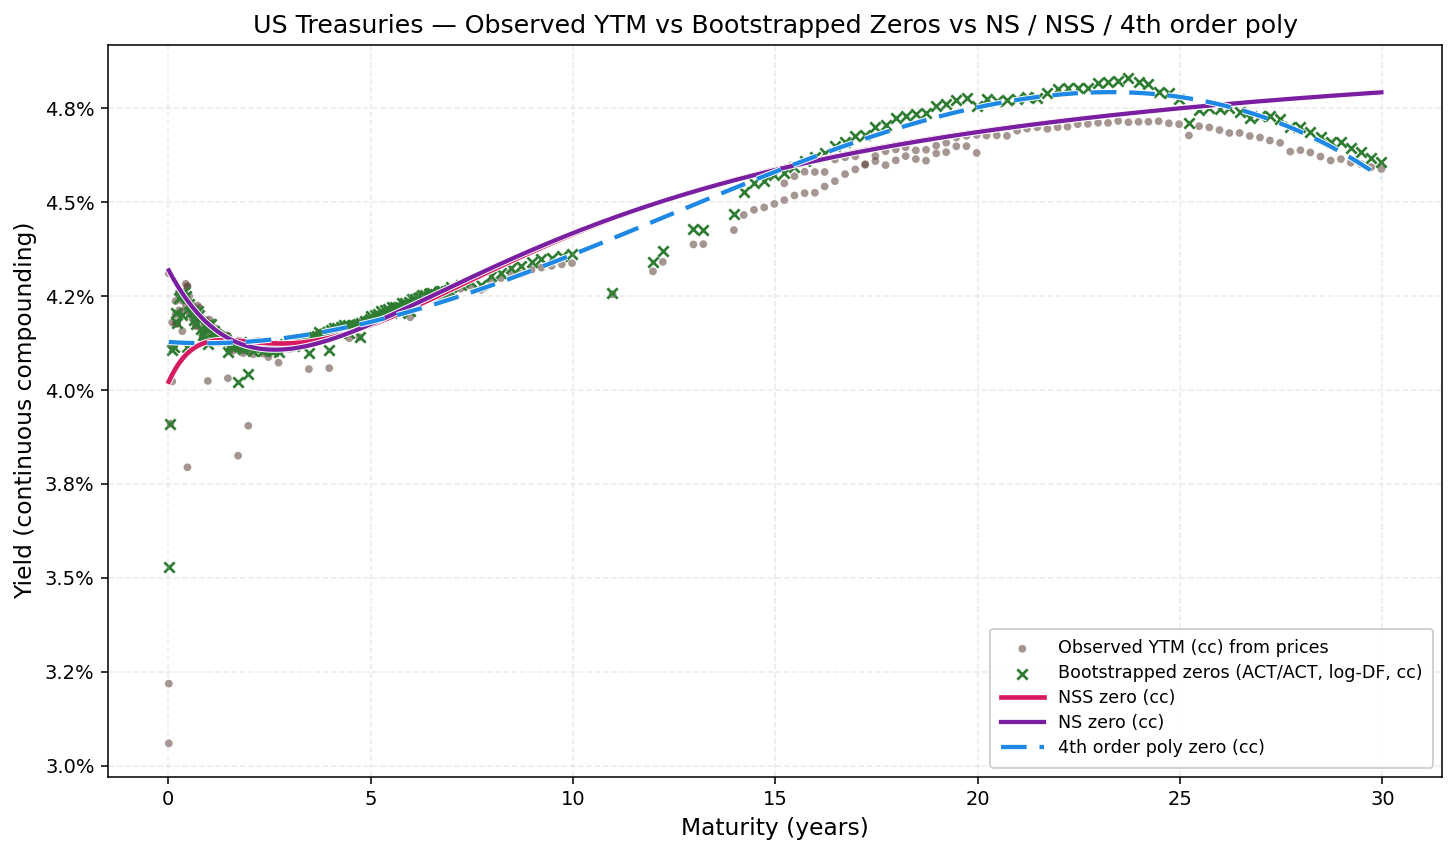

In [7]:
# Combined Curve Plot: YTM (from prices) + Bootstrapped zeros + NS / NSS / Cheb-4

# Models
theta_nss = fitted_params            # [b0,b1,b2,b3,t1,t2]
theta_ns  = fitted_params_ns         # [b0,b1,b2,t1]
cheb_coeffs = fitted_coeffs_cheb     # length 5
# Bootstrap nodes (ACT/ACT years, zero cc)
boot_nodes_list = boot_nodes         # [(T, y_cc(T)), ...]

# Helpers (light wrappers that use your existing functions) 
def nss_zero(t):
    b0,b1,b2,b3,t1,t2 = theta_nss
    return nelson_siegel_svensson_yield(t, b0,b1,b2,b3,t1,t2)

def ns_zero(t):
    b0,b1,b2,t1 = theta_ns
    return nelson_siegel_yield(t, b0,b1,b2,t1)

# Chebyshev mapping (same as earlier)
def _scale_to_cheb_domain(t, T_max):
    tt = min(max(t, 0.0), T_max)
    return 2.0 * (tt / T_max) - 1.0

from numpy.polynomial.chebyshev import chebval
def cheb_zero(t, coeffs, T_max):
    x = _scale_to_cheb_domain(t, T_max)
    return float(chebval(x, coeffs))

# Build data series on a common grid 
try:
    T_mkt = np.array([b["Maturity_T"] for b in all_cashflows_T], float)
    YTM_mkt = np.array([ytm_cc_from_price(b, b["Dirty Price"]) for b in all_cashflows_T], float)
except NameError as e:
    raise RuntimeError("Missing all_cashflows_T or ytm_cc_from_price") from e

# Grid up to your longest maturity in data
T_max = float(np.nanmax(T_mkt))
T_grid = np.linspace(0.01, T_max, 600)

# Evaluate models
Y_nss  = np.array([nss_zero(t) for t in T_grid], float)
Y_ns   = np.array([ns_zero(t)  for t in T_grid], float)
Y_cheb = np.array([cheb_zero(t, cheb_coeffs, T_max) for t in T_grid], float)

# Bootstrapped nodes
T_boot = np.array([T for T, y in boot_nodes_list], float)
Y_boot = np.array([y for T, y in boot_nodes_list], float)

# Plotting
plt.figure(figsize=(10.5, 6.2), dpi=140)

c_nss  = "#D81B60"   # deep pink/red
c_ns   = "#7B1FA2"   # purple
c_cheb = "#1E88E5"   # blue
c_boot = "#2E7D32"   # green
c_ytm  = "#5D4037"   # brown-ish for dots

# Observed YTM 
plt.scatter(T_mkt, YTM_mkt, s=16, alpha=0.55, label="Observed YTM (cc) from prices",
            color=c_ytm, edgecolor="none")

# Bootstrapped zeros (nodes as X markers)
plt.scatter(T_boot, Y_boot, s=28, marker="x", linewidths=1.4, color=c_boot,
            label="Bootstrapped zeros (ACT/ACT, log-DF, cc)")

# Model lines
plt.plot(T_grid, Y_nss,  lw=2.4, color=c_nss,  label="NSS zero (cc)",
         path_effects=[pe.Stroke(linewidth=3.4, foreground="white"), pe.Normal()])
plt.plot(T_grid, Y_ns,   lw=2.2, color=c_ns,   label="NS zero (cc)",
         path_effects=[pe.Stroke(linewidth=3.2, foreground="white"), pe.Normal()])
plt.plot(T_grid, Y_cheb, lw=2.2, color=c_cheb, label="4th order poly zero (cc)",
         linestyle=(0,(6,3)), path_effects=[pe.Stroke(linewidth=3.2, foreground="white"), pe.Normal()])

# Axes & labels
plt.xlabel("Maturity (years)", fontsize=12)
plt.ylabel("Yield (continuous compounding)", fontsize=12)
plt.title("US Treasuries — Observed YTM vs Bootstrapped Zeros vs NS / NSS / 4th order poly", fontsize=13)

plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=1))

# Nice grid
plt.grid(True, which="major", alpha=0.25, linestyle="--")

lg = plt.legend(
    frameon=True,
    loc="lower right",
    fontsize=9,        
    borderpad=0.6,
    labelspacing=0.4,
    handlelength=2.5,
)
lg.get_frame().set_alpha(0.92)

plt.tight_layout()
plt.savefig("yield_curve_comparison.png", dpi=300, bbox_inches="tight") 

plt.show()



In [8]:
# Results

# Build a grid (e.g. every 1 year, or choose your own maturities)
T_table = np.arange(1, int(T_max)+1)  # yearly maturities

# Compute model yields at these maturities
table_data = {
    "Maturity (yrs)": T_table,
    "Bootstrapped Zero (cc)": [np.interp(t, T_boot, Y_boot) for t in T_table],
    "NS Zero (cc)":  [ns_zero(t) for t in T_table],
    "NSS Zero (cc)": [nss_zero(t) for t in T_table],
    "Poly-4 Zero (cc)": [cheb_zero(t, cheb_coeffs, T_max) for t in T_table],
}

results_df = pd.DataFrame(table_data)

# Display nicely
print(results_df.to_string(index=False))

# Optional: save to Excel or LaTeX
results_df.to_excel("yield_curve_results.xlsx", index=False)
# results_df.to_latex("yield_curve_results.tex", index=False, float_format="%.4f")

 Maturity (yrs)  Bootstrapped Zero (cc)  NS Zero (cc)  NSS Zero (cc)  Poly-4 Zero (cc)
              1                0.041593      0.041745       0.041286          0.041246
              2                0.040901      0.041157       0.041287          0.041289
              3                0.041232      0.041096       0.041242          0.041402
              4                0.041443      0.041342       0.041392          0.041579
              5                0.041944      0.041752       0.041726          0.041813
              6                0.042316      0.042240       0.042176          0.042098
              7                0.042753      0.042752       0.042680          0.042426
              8                0.043051      0.043255       0.043193          0.042792
              9                0.043416      0.043733       0.043687          0.043188
             10                0.043604      0.044177       0.044148          0.043608
             11                0.042609    

In [9]:
coef_data = {
    "Model": ["Nelson–Siegel", "Nelson–Siegel–Svensson", "Chebyshev-4"],
    "Parameters": [
        {
            "β0": theta_ns[0],
            "β1": theta_ns[1],
            "β2": theta_ns[2],
            "τ1": theta_ns[3],
        },
        {
            "β0": theta_nss[0],
            "β1": theta_nss[1],
            "β2": theta_nss[2],
            "β3": theta_nss[3],
            "τ1": theta_nss[4],
            "τ2": theta_nss[5],
        },
        {
            "c0": cheb_coeffs[0],
            "c1": cheb_coeffs[1],
            "c2": cheb_coeffs[2],
            "c3": cheb_coeffs[3],
            "c4": cheb_coeffs[4],
        }
    ]
}

# Convert to DataFrame
coef_rows = []
for model, params in zip(coef_data["Model"], coef_data["Parameters"]):
    for k, v in params.items():
        coef_rows.append({"Model": model, "Parameter": k, "Value": v})

coef_df = pd.DataFrame(coef_rows)

print(coef_df.to_string(index=False))

# Optional: export to Excel or LaTeX
coef_df.to_excel("model_coefficients.xlsx", index=False)
# coef_df.to_latex("model_coefficients.tex", index=False, float_format="%.6f")


                 Model Parameter     Value
         Nelson–Siegel        β0  0.050063
         Nelson–Siegel        β1 -0.006859
         Nelson–Siegel        β2 -0.017615
         Nelson–Siegel        τ1  2.621500
Nelson–Siegel–Svensson        β0  0.049998
Nelson–Siegel–Svensson        β1 -0.009801
Nelson–Siegel–Svensson        β2  0.008867
Nelson–Siegel–Svensson        β3 -0.027199
Nelson–Siegel–Svensson        τ1  1.106362
Nelson–Siegel–Svensson        τ2  2.259207
           Chebyshev-4        c0  0.044658
           Chebyshev-4        c1  0.003226
           Chebyshev-4        c2 -0.001169
           Chebyshev-4        c3 -0.001036
           Chebyshev-4        c4 -0.000020
